In [1]:
import dill
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from numpy import unique

In [2]:
# set figure size globally
sns.set(rc={'figure.figsize':(15,12)})
sns.set_style('whitegrid')

## Load dataframes

In [3]:
# reload dsfs
with open('repeat_metrics_df' + '_wisdm_' +  '5m10r' + '.pkl', 'rb') as in_strm:
    repeat_metrics_df = dill.load(in_strm)

with open("mean_metrics_df" + '_wisdm_' + '5m10r' +  '.pkl', 'rb') as in_strm:
    mean_metrics_df = dill.load(in_strm)

with open('repeat_epoch_accuracies_train_df' + '_wisdm_' +  '5m10r' + '.pkl', 'rb') as in_strm:
    repeat_epoch_accuracies_train_df = dill.load(in_strm)

with open('repeat_epoch_accuracies_test_df' + '_wisdm_' + '5m10r' +  '.pkl', 'rb') as in_strm:
    repeat_epoch_accuracies_test_df = dill.load(in_strm)

with open('repeat_epoch_accuracies_df' + '_wisdm_' + '5m10r' +  '.pkl', 'rb') as in_strm:
    repeat_epoch_accuracies_df = dill.load(in_strm)

## t-test functions

In [4]:
# make list of all different models
model_plain_list = repeat_metrics_df.model_plain.unique()

In [5]:
# Make a function to iterate throguh models, performoing t tests on each
def welch_t_test_loop(metric='test_accuracy', df=repeat_metrics_df):
    
    # Get names of models
    model_plain_list = df.model_plain.unique()
    
    # make dict to store metric for each iteration of each model
    model_plain_dict = {}
    
    # add model metrics to the list
    for model in model_plain_list:
            model_plain_dict[str(model)] = np.array(df[df['model_plain']==model][metric])         

    # get keys and values
    model_plain_dict_keys = list(model_plain_dict.keys())
    model_plain_dict_values = list(model_plain_dict.values())
    
    # loop through to get t test resuults
    t_test_dict = {}
    for i in range(len(model_plain_dict_keys)):
        for j in range(len(model_plain_dict_values)):
            t_test_result = ttest_ind(model_plain_dict_values[i], model_plain_dict_values[j], equal_var=False)
            t_test_dict[model_plain_dict_keys[i] + "_vs_" + model_plain_dict_keys[j]] = t_test_result
            
    return t_test_dict

In [6]:
# get p values for test accuracy
acc_p_values = welch_t_test_loop()
acc_p_values

{'lstm_standard_original_vs_lstm_standard_original': Ttest_indResult(statistic=0.0, pvalue=1.0),
 'lstm_standard_original_vs_cnnlstm_standard_original': Ttest_indResult(statistic=-4.748469366970376, pvalue=0.00019020304192620533),
 'lstm_standard_original_vs_convlstm_standard_original': Ttest_indResult(statistic=-1.7182490648493527, pvalue=0.10292473724847431),
 'lstm_standard_original_vs_bilstm_standard_original': Ttest_indResult(statistic=-0.8505626597720792, pvalue=0.4061878969366677),
 'lstm_standard_original_vs_lstm_standard_balanced': Ttest_indResult(statistic=-0.7965327607798104, pvalue=0.4385809450723043),
 'lstm_standard_original_vs_cnnlstm_standard_balanced': Ttest_indResult(statistic=-1.8247372376228688, pvalue=0.08864159383977359),
 'lstm_standard_original_vs_convlstm_standard_balanced': Ttest_indResult(statistic=-0.16450291092982566, pvalue=0.8712758898475637),
 'lstm_standard_original_vs_bilstm_standard_balanced': Ttest_indResult(statistic=2.6989337483212137, pvalue=0.017

In [7]:
# get p values for test accuracy
f1_p_values = welch_t_test_loop(metric='f1_score')
f1_p_values

{'lstm_standard_original_vs_lstm_standard_original': Ttest_indResult(statistic=0.0, pvalue=1.0),
 'lstm_standard_original_vs_cnnlstm_standard_original': Ttest_indResult(statistic=-5.069809662067028, pvalue=9.137692580949027e-05),
 'lstm_standard_original_vs_convlstm_standard_original': Ttest_indResult(statistic=-1.4638742687637907, pvalue=0.16052784826404173),
 'lstm_standard_original_vs_bilstm_standard_original': Ttest_indResult(statistic=-1.2895752753473178, pvalue=0.21358083752120255),
 'lstm_standard_original_vs_lstm_standard_balanced': Ttest_indResult(statistic=-1.056397656054136, pvalue=0.30913765383106284),
 'lstm_standard_original_vs_cnnlstm_standard_balanced': Ttest_indResult(statistic=-2.8731173565131622, pvalue=0.01123082983299606),
 'lstm_standard_original_vs_convlstm_standard_balanced': Ttest_indResult(statistic=-0.5600374464071584, pvalue=0.5826201811927476),
 'lstm_standard_original_vs_bilstm_standard_balanced': Ttest_indResult(statistic=1.7805146103818235, pvalue=0.0966

In [8]:
# make function to return t-test result for a pair of models
def t_test_pair(p_values_dict, model1, model2):
    return p_values_dict[model1 + '_vs_' + model2]

In [9]:
# make function to return t-test result for one model vs the rest
def t_test_pair_all(p_values_dict, model, data):
    
    models_selected= list()
    
    # select either original or feature reduced dataset
    if(data == 'original'):
        for model_plain in model_plain_list:
            if (model_plain.find("original") != -1):
                models_selected.append(model_plain)
    if(data == 'reduced'):
        for model_plain in model_plain_list:
            if (model_plain.find("reduced") != -1):
                models_selected.append(model_plain)
    if(data == 'balanced'):
        for model_plain in model_plain_list:
            if (model_plain.find("balanced") != -1):
                models_selected.append(model_plain)
    
    for models in models_selected:
        print('\n', models)
        print(p_values_dict[model + '_vs_' + models])

## Stage 1: Original data

### Mean final accuracies and F1 scores

In [10]:
# make a function to display mean accuracies (%) and sd
def display_accuracies(data):
    df = mean_metrics_df[['mean_test_accuracy', 'test_accuracy_sd']][mean_metrics_df['data_used'] == data].round(4)*100
    df['model'] = mean_metrics_df['model_plain']
    return df

In [11]:
# make a function to display mean f1 scores and sd
def display_f1(data):
    df = mean_metrics_df[['mean_f1_score', 'f1_score_sd']][mean_metrics_df['data_used'] == data].round(4)
    df['model'] = mean_metrics_df['model_plain']
    return df

In [12]:
display_accuracies('original')

,mean_test_accuracy,test_accuracy_sd,model
lstm_original,81.76,0.59,lstm_standard_original
cnnlstm_original,83.29,0.77,cnnlstm_standard_original
convlstm_original,82.24,0.61,convlstm_standard_original
bilstm_original,81.99,0.58,bilstm_standard_original
lstm_original_dac,81.40,1.05,lstm_divide_and_conquer_original
cnnlstm_original_dac,81.61,0.58,cnnlstm_divide_and_conquer_original
convlstm_original_dac,81.61,0.43,convlstm_divide_and_conquer_original
bilstm_original_dac,81.65,1.31,bilstm_divide_and_conquer_original


In [13]:
display_f1('original')

,mean_f1_score,f1_score_sd,model
lstm_original,0.8199,0.0052,lstm_standard_original
cnnlstm_original,0.8340,0.0065,cnnlstm_standard_original
convlstm_original,0.8236,0.0055,convlstm_standard_original
bilstm_original,0.8232,0.0056,bilstm_standard_original
lstm_original_dac,0.8175,0.0102,lstm_divide_and_conquer_original
cnnlstm_original_dac,0.8184,0.0054,cnnlstm_divide_and_conquer_original
convlstm_original_dac,0.8160,0.0043,convlstm_divide_and_conquer_original
bilstm_original_dac,0.8212,0.0125,bilstm_divide_and_conquer_original


### t-tests

In [14]:
# function to sort by f1 score
def sort_f1(df):
    return df.sort_values('mean_f1_score', ascending=False)

In [15]:
sort_f1(display_f1('original'))

,mean_f1_score,f1_score_sd,model
cnnlstm_original,0.8340,0.0065,cnnlstm_standard_original
convlstm_original,0.8236,0.0055,convlstm_standard_original
bilstm_original,0.8232,0.0056,bilstm_standard_original
bilstm_original_dac,0.8212,0.0125,bilstm_divide_and_conquer_original
lstm_original,0.8199,0.0052,lstm_standard_original
cnnlstm_original_dac,0.8184,0.0054,cnnlstm_divide_and_conquer_original
lstm_original_dac,0.8175,0.0102,lstm_divide_and_conquer_original
convlstm_original_dac,0.8160,0.0043,convlstm_divide_and_conquer_original


In [16]:
t_test_pair_all(f1_p_values, 'cnnlstm_standard_original', 'original')


 lstm_standard_original
Ttest_indResult(statistic=5.069809662067028, pvalue=9.137692580949027e-05)

 cnnlstm_standard_original
Ttest_indResult(statistic=0.0, pvalue=1.0)

 convlstm_standard_original
Ttest_indResult(statistic=3.650289757441727, pvalue=0.0018954821267505241)

 bilstm_standard_original
Ttest_indResult(statistic=3.7970114741705783, pvalue=0.0013696144613106385)

 lstm_divide_and_conquer_original
Ttest_indResult(statistic=4.0964528541108125, pvalue=0.0009163104825625625)

 cnnlstm_divide_and_conquer_original
Ttest_indResult(statistic=5.510990671465086, pvalue=3.510406194428106e-05)

 convlstm_divide_and_conquer_original
Ttest_indResult(statistic=6.914570292577762, pvalue=4.086784051804997e-06)

 bilstm_divide_and_conquer_original
Ttest_indResult(statistic=2.7241544195295817, pvalue=0.016856497577887944)


### Plots

In [17]:
# function tomake list to store model type (whether dac or standard model)
def model_type_fn(df, model="model_plain"):

    model_type = list()
    for i in range(len(df)):
        if (df[model][i].find("standard") == -1):
            model_type.append("divide_and_conquer")
        else:
            model_type.append("standard") 
            
    return model_type

In [18]:
# function to make list to store model family
def model_family_fn(df):
    family = list()
    for i in range(len(df)):
        if (df['model_plain'][i][0] == "l"):
            family.append("lstm")
        elif (df['model_plain'][i][0] == "c"):
            if (df['model_plain'][i][1] == "n"):
                family.append("cnnlstm")
            else:
                family.append("convlstm")
        else:
            family.append("bilstm")
    
    return family

In [19]:
# function tomake list to store model type (whether dac or standard model)
def data_used_fn(df, model="model"):

    data_used = list()
    for i in range(len(df)):
        if ("original" in  df[model][i]):
            data_used.append("original")
        elif ("balanced" in df[model][i]):
            data_used.append("balanced")
        elif ("reduced" in df[model][i]):
            data_used.append("reduced")
            
    return data_used

In [20]:
# make function to get the mean accuracy/training times of epochs for the data, depending on what is selected, and plot it
def plot_mean_and_sd(col, condition, types=None, title=None, labels='default', df=repeat_epoch_accuracies_test_df):
    
    # make df of mean accuracy and time per epoch
    test_mean_accuracies_times = df[df[col]==condition].fillna(method='ffill').groupby(['model_plain','epoch']).mean()
    test_mean_accuracies_times.reset_index(inplace=True)  
    
    # make column to show whether dac or standard
    test_mean_accuracies_times['model_type'] = model_type_fn(test_mean_accuracies_times)
    
    # add column to show model family
    test_mean_accuracies_times['family'] = model_family_fn(test_mean_accuracies_times)
    # get sd
    sd = df[df[col]==condition].groupby(['model_plain','epoch']).std()
    sd_acc = list(sd.accuracy)
    test_mean_accuracies_times['sd_acc'] = sd_acc

    #get lower and upper bounds of sd
    test_mean_accuracies_times['acc_lower'] = test_mean_accuracies_times['accuracy'] - test_mean_accuracies_times['sd_acc']
    test_mean_accuracies_times['acc_upper'] = test_mean_accuracies_times['accuracy'] + test_mean_accuracies_times['sd_acc']

    # get min and max also
    mins = df[df[col]==condition].groupby(['model_plain','epoch']).min()
    maxes = df[df[col]==condition].groupby(['model_plain','epoch']).max()

    # convert the times to a list for the df
    min_acc = list(mins.accuracy)
    max_acc = list(maxes.accuracy)

    test_mean_accuracies_times['min_acc'] = min_acc
    test_mean_accuracies_times['max_acc'] = max_acc

    # get names of the models to be plotted
    models_list=unique(test_mean_accuracies_times['model_plain'])
    
    # if no labels inputted, set the legend labels to default 
    if (labels=='default'):
        labels=None
    
#     print(test_mean_accuracies_times)
        
    # plot the lines for each model    
    ax = sns.lineplot(x = 'time', 
              y = 'accuracy', 
              data=test_mean_accuracies_times,
              style='model_type',
              hue='family',
              ci='sd',
            )
    
    # add legend. user can set custom labels for aesthetics
    ax.legend(loc = 'lower right',
             labels=labels,
             prop={'size': 16})
    
    # limit for consistency
    ax.set(ylim=(0, 1),
          xlim=(0, None))
    
    ax.set(title=title,
       xlabel='Time (s)',
       ylabel='Accuracy')
    
    # add sd bars, if only comparing 1 type of model
    if types == "one":
        # iterate through, adding sd bars for each moddel selected by condition
        for i in range(len(models_list)):
            ax.fill_between('time',
                  'acc_lower', 
                  'acc_upper',
                  data=test_mean_accuracies_times[test_mean_accuracies_times['model_plain']==models_list[i]],
                  alpha=0.1)
            

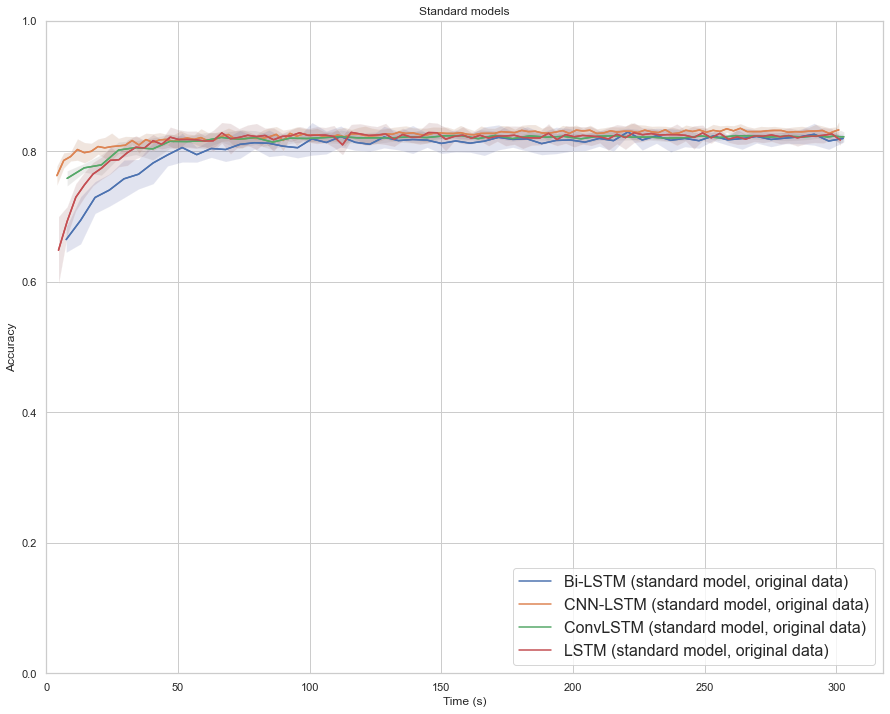

In [21]:
# plot just standard, non-dac models which were trrained on the original data
plot_mean_and_sd('data_used_and_model_type', 'original_standard', types='one')

# # Now make with better labels
labels = ['Bi-LSTM (standard model, original data)', 'CNN-LSTM (standard model, original data)', 'ConvLSTM (standard model, original data)', 'LSTM (standard model, original data)']
plot_mean_and_sd('data_used_and_model_type', 'original_standard', types='one', title="Standard models", labels=labels)

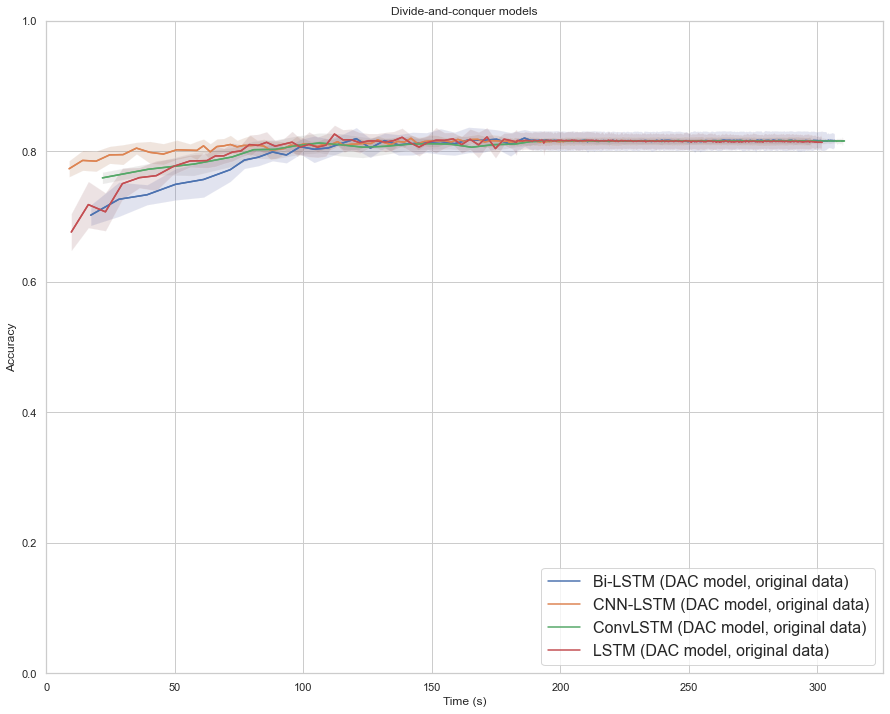

In [22]:
# plot just dac models which were trrained on the original data
plot_mean_and_sd('data_used_and_model_type', 'original_divide_and_conquer', types='one')

# Now make with better labels
labels = ['Bi-LSTM (DAC model, original data)', 'CNN-LSTM (DAC model, original data)', 'ConvLSTM (DAC model, original data)', 'LSTM (DAC model, original data)']
plot_mean_and_sd('data_used_and_model_type', 'original_divide_and_conquer', types='one', title="Divide-and-conquer models", labels=labels)

## Stage 2: after oversampling

### Mean final accuracies and F1 scores

In [23]:
display_accuracies('balanced')

,mean_test_accuracy,test_accuracy_sd,model
lstm_balanced,82.07,1.01,lstm_standard_balanced
cnnlstm_balanced,82.46,1.00,cnnlstm_standard_balanced
convlstm_balanced,81.81,0.76,convlstm_standard_balanced
bilstm_balanced,80.60,1.14,bilstm_standard_balanced
lstm_balanced_dac,80.93,1.13,lstm_divide_and_conquer_balanced
cnnlstm_balanced_dac,80.19,1.36,cnnlstm_divide_and_conquer_balanced
convlstm_balanced_dac,79.95,1.48,convlstm_divide_and_conquer_balanced
bilstm_balanced_dac,80.24,1.75,bilstm_divide_and_conquer_balanced


In [24]:
display_f1('balanced')

,mean_f1_score,f1_score_sd,model
lstm_balanced,0.8238,0.0099,lstm_standard_balanced
cnnlstm_balanced,0.8289,0.0079,cnnlstm_standard_balanced
convlstm_balanced,0.8214,0.0064,convlstm_standard_balanced
bilstm_balanced,0.8135,0.0095,bilstm_standard_balanced
lstm_balanced_dac,0.8143,0.0112,lstm_divide_and_conquer_balanced
cnnlstm_balanced_dac,0.8084,0.0127,cnnlstm_divide_and_conquer_balanced
convlstm_balanced_dac,0.8041,0.0124,convlstm_divide_and_conquer_balanced
bilstm_balanced_dac,0.8111,0.0163,bilstm_divide_and_conquer_balanced


### t-tests

In [25]:
sort_f1(display_f1('balanced'))

,mean_f1_score,f1_score_sd,model
cnnlstm_balanced,0.8289,0.0079,cnnlstm_standard_balanced
lstm_balanced,0.8238,0.0099,lstm_standard_balanced
convlstm_balanced,0.8214,0.0064,convlstm_standard_balanced
lstm_balanced_dac,0.8143,0.0112,lstm_divide_and_conquer_balanced
bilstm_balanced,0.8135,0.0095,bilstm_standard_balanced
bilstm_balanced_dac,0.8111,0.0163,bilstm_divide_and_conquer_balanced
cnnlstm_balanced_dac,0.8084,0.0127,cnnlstm_divide_and_conquer_balanced
convlstm_balanced_dac,0.8041,0.0124,convlstm_divide_and_conquer_balanced


In [26]:
t_test_pair_all(f1_p_values, 'cnnlstm_standard_balanced', 'balanced')


 lstm_standard_balanced
Ttest_indResult(statistic=1.208228470868667, pvalue=0.2433899652289334)

 cnnlstm_standard_balanced
Ttest_indResult(statistic=0.0, pvalue=1.0)

 convlstm_standard_balanced
Ttest_indResult(statistic=2.2239991478685175, pvalue=0.03977140368597022)

 bilstm_standard_balanced
Ttest_indResult(statistic=3.771520228409363, pvalue=0.0014655412036727181)

 lstm_divide_and_conquer_balanced
Ttest_indResult(statistic=3.20661215129201, pvalue=0.005450156224540922)

 cnnlstm_divide_and_conquer_balanced
Ttest_indResult(statistic=4.1274827581708315, pvalue=0.0008911651228454713)

 convlstm_divide_and_conquer_balanced
Ttest_indResult(statistic=5.049404453722885, pvalue=0.00013797185585020716)

 bilstm_divide_and_conquer_balanced
Ttest_indResult(statistic=2.9527893807224497, pvalue=0.011210451587122304)


### Plots

In [27]:
# make function to get the mean accuracy/training times of epochs for the data, depending on what is selected, and plot it
def plot_mean_and_sd(col, condition, types=None, title=None, labels='default', df=repeat_epoch_accuracies_test_df):
    
    # make df of mean accuracy and time per epoch
    test_mean_accuracies_times = df[df[col]==condition].fillna(method='ffill').groupby(['model_plain','epoch']).mean()
    test_mean_accuracies_times.reset_index(inplace=True)  
    
    # make column to show whether dac or standard
    test_mean_accuracies_times['model_type'] = model_type_fn(test_mean_accuracies_times)
    
    # add column to show model family
    test_mean_accuracies_times['family'] = model_family_fn(test_mean_accuracies_times)
    # get sd
    sd = df[df[col]==condition].groupby(['model_plain','epoch']).std()
    sd_acc = list(sd.accuracy)
    test_mean_accuracies_times['sd_acc'] = sd_acc

    #get lower and upper bounds of sd
    test_mean_accuracies_times['acc_lower'] = test_mean_accuracies_times['accuracy'] - test_mean_accuracies_times['sd_acc']
    test_mean_accuracies_times['acc_upper'] = test_mean_accuracies_times['accuracy'] + test_mean_accuracies_times['sd_acc']

    # get min and max also
    mins = df[df[col]==condition].groupby(['model_plain','epoch']).min()
    maxes = df[df[col]==condition].groupby(['model_plain','epoch']).max()

    # convert the times to a list for the df
    min_acc = list(mins.accuracy)
    max_acc = list(maxes.accuracy)

    test_mean_accuracies_times['min_acc'] = min_acc
    test_mean_accuracies_times['max_acc'] = max_acc

    # get names of the models to be plotted
    models_list=unique(test_mean_accuracies_times['model_plain'])
    
    # if no labels inputted, set the legend labels to default 
    if (labels=='default'):
        labels=None
    
#     print(test_mean_accuracies_times)
        
    # plot the lines for each model    
    ax = sns.lineplot(x = 'time', 
              y = 'accuracy', 
              data=test_mean_accuracies_times,
              style='model_type',
              hue='family',
              ci='sd',
            )
    
    # add legend. user can set custom labels for aesthetics
    ax.legend(loc = 'lower right',
             labels=labels,
             prop={'size': 16})
    
    # limit for consistency
    ax.set(ylim=(0, 1),
          xlim=(0, None))
    
    ax.set(title=title,
       xlabel='Time (s)',
       ylabel='Accuracy')
    
    # add sd bars, if only comparing 1 type of model
    if types == "one":
        # iterate through, adding sd bars for each moddel selected by condition
        for i in range(len(models_list)):
            ax.fill_between('time',
                  'acc_lower', 
                  'acc_upper',
                  data=test_mean_accuracies_times[test_mean_accuracies_times['model_plain']==models_list[i]],
                  alpha=0.1)
            

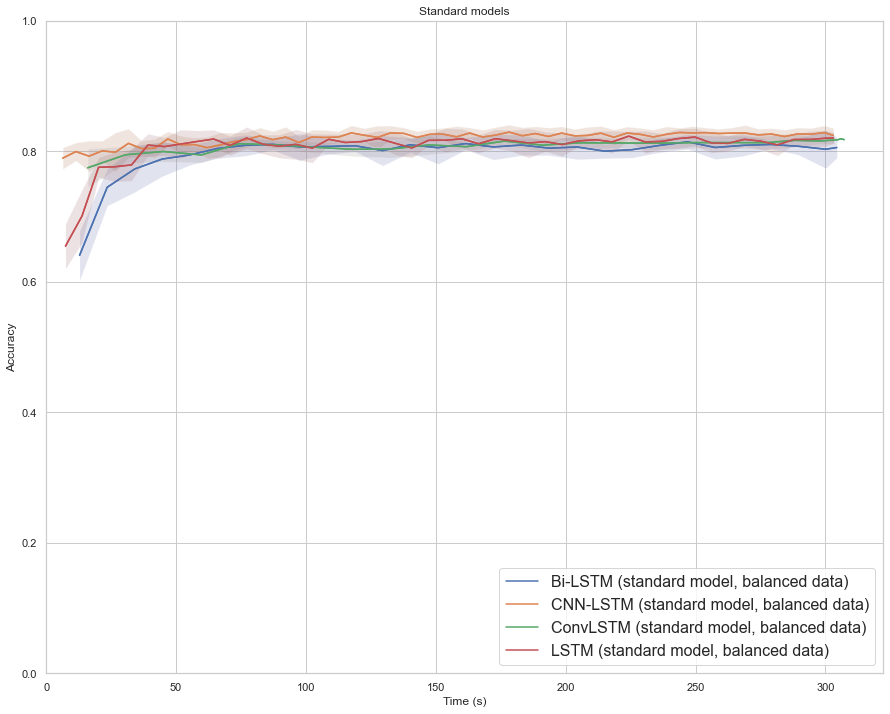

In [28]:
# plot just standard, non-dac models which were trrained on the original data
plot_mean_and_sd('data_used_and_model_type', 'balanced_standard', types='one')

# Now make with better labels
labels = ['Bi-LSTM (standard model, balanced data)', 'CNN-LSTM (standard model, balanced data)', 'ConvLSTM (standard model, balanced data)', 'LSTM (standard model, balanced data)']
plot_mean_and_sd('data_used_and_model_type', 'balanced_standard', types='one', title="Standard models", labels=labels)

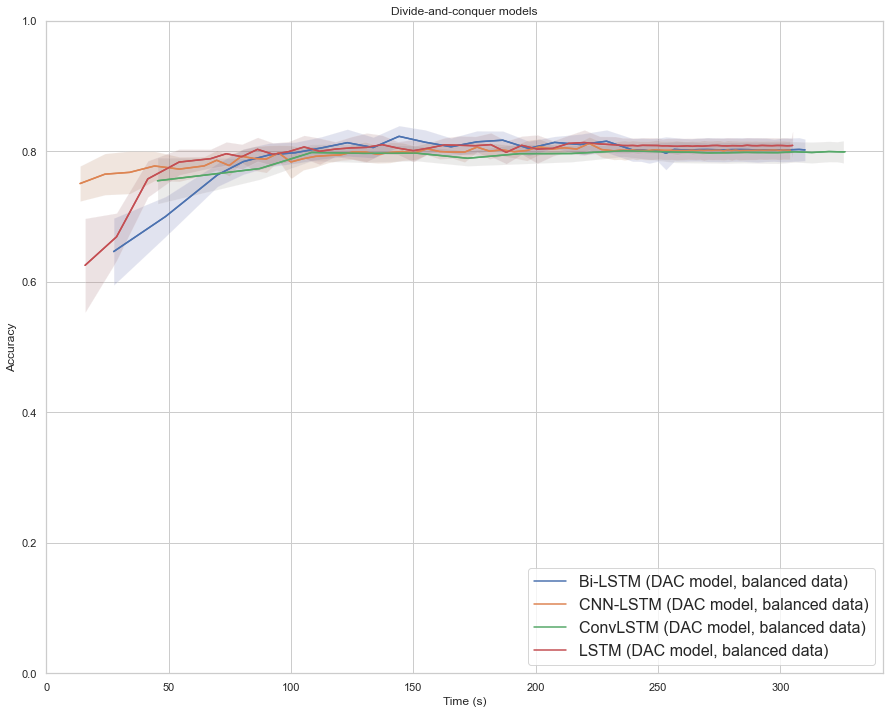

In [29]:
# plot just dac models which were trrained on the original data
plot_mean_and_sd('data_used_and_model_type', 'balanced_divide_and_conquer', types='one')

# Now make with better labels
labels = ['Bi-LSTM (DAC model, balanced data)', 'CNN-LSTM (DAC model, balanced data)', 'ConvLSTM (DAC model, balanced data)', 'LSTM (DAC model, balanced data)']
plot_mean_and_sd('data_used_and_model_type', 'balanced_divide_and_conquer', types='one', title="Divide-and-conquer models", labels=labels)

## Stage 3: Dataset after feature selection

### Mean final model accuracies etc

In [30]:
display_accuracies('reduced')

,mean_test_accuracy,test_accuracy_sd,model
lstm_reduced,84.75,0.59,lstm_standard_reduced
cnnlstm_reduced,85.07,0.49,cnnlstm_standard_reduced
convlstm_reduced,84.00,0.48,convlstm_standard_reduced
bilstm_reduced,84.60,0.63,bilstm_standard_reduced
lstm_reduced_dac,84.43,0.42,lstm_divide_and_conquer_reduced
cnnlstm_reduced_dac,85.05,0.43,cnnlstm_divide_and_conquer_reduced
convlstm_reduced_dac,81.84,0.37,convlstm_divide_and_conquer_reduced
bilstm_reduced_dac,84.10,0.66,bilstm_divide_and_conquer_reduced


In [31]:
display_f1('reduced')

,mean_f1_score,f1_score_sd,model
lstm_reduced,0.8512,0.0049,lstm_standard_reduced
cnnlstm_reduced,0.8520,0.0041,cnnlstm_standard_reduced
convlstm_reduced,0.8456,0.0041,convlstm_standard_reduced
bilstm_reduced,0.8506,0.0059,bilstm_standard_reduced
lstm_reduced_dac,0.8494,0.0043,lstm_divide_and_conquer_reduced
cnnlstm_reduced_dac,0.8520,0.0037,cnnlstm_divide_and_conquer_reduced
convlstm_reduced_dac,0.8196,0.0039,convlstm_divide_and_conquer_reduced
bilstm_reduced_dac,0.8469,0.0057,bilstm_divide_and_conquer_reduced


### Perform t-tests to see if significant

In [32]:
sort_f1(display_f1('reduced'))

,mean_f1_score,f1_score_sd,model
cnnlstm_reduced,0.8520,0.0041,cnnlstm_standard_reduced
cnnlstm_reduced_dac,0.8520,0.0037,cnnlstm_divide_and_conquer_reduced
lstm_reduced,0.8512,0.0049,lstm_standard_reduced
bilstm_reduced,0.8506,0.0059,bilstm_standard_reduced
lstm_reduced_dac,0.8494,0.0043,lstm_divide_and_conquer_reduced
bilstm_reduced_dac,0.8469,0.0057,bilstm_divide_and_conquer_reduced
convlstm_reduced,0.8456,0.0041,convlstm_standard_reduced
convlstm_reduced_dac,0.8196,0.0039,convlstm_divide_and_conquer_reduced


In [33]:
t_test_pair_all(f1_p_values, 'cnnlstm_standard_reduced', 'reduced')


 lstm_standard_reduced
Ttest_indResult(statistic=0.3991443561470781, pvalue=0.6946284674234849)

 cnnlstm_standard_reduced
Ttest_indResult(statistic=0.0, pvalue=1.0)

 convlstm_standard_reduced
Ttest_indResult(statistic=3.322680844774565, pvalue=0.0037881181615749093)

 bilstm_standard_reduced
Ttest_indResult(statistic=0.5903419362011028, pvalue=0.5631882964398492)

 lstm_divide_and_conquer_reduced
Ttest_indResult(statistic=1.2959017960938393, pvalue=0.21144014624108973)

 cnnlstm_divide_and_conquer_reduced
Ttest_indResult(statistic=0.006646179281127916, pvalue=0.9947710128876132)

 convlstm_divide_and_conquer_reduced
Ttest_indResult(statistic=17.157871790178234, pvalue=1.3572333404227154e-12)

 bilstm_divide_and_conquer_reduced
Ttest_indResult(statistic=2.2031725259300483, pvalue=0.04228660187247964)


### Plots

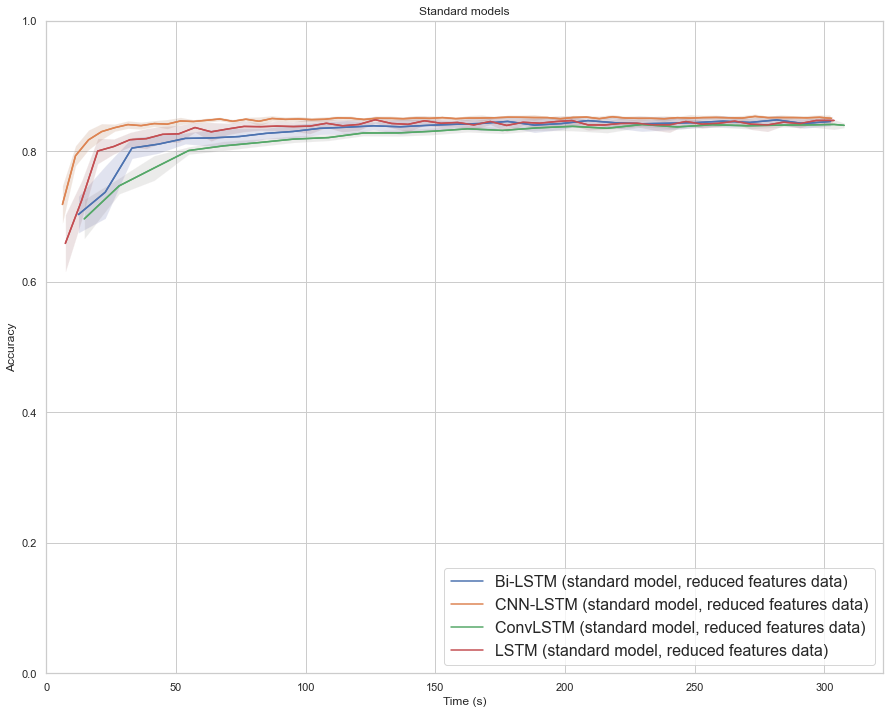

In [34]:
# plot just standard, non-dac models which were trrained on the original data
plot_mean_and_sd('data_used_and_model_type', 'reduced_standard', types='one')

# Now make with better labels
labels = ['Bi-LSTM (standard model, reduced features data)', 'CNN-LSTM (standard model, reduced features data)', 'ConvLSTM (standard model, reduced features data)', 'LSTM (standard model, reduced features data)']
plot_mean_and_sd('data_used_and_model_type', 'reduced_standard', types='one', title="Standard models", labels=labels)

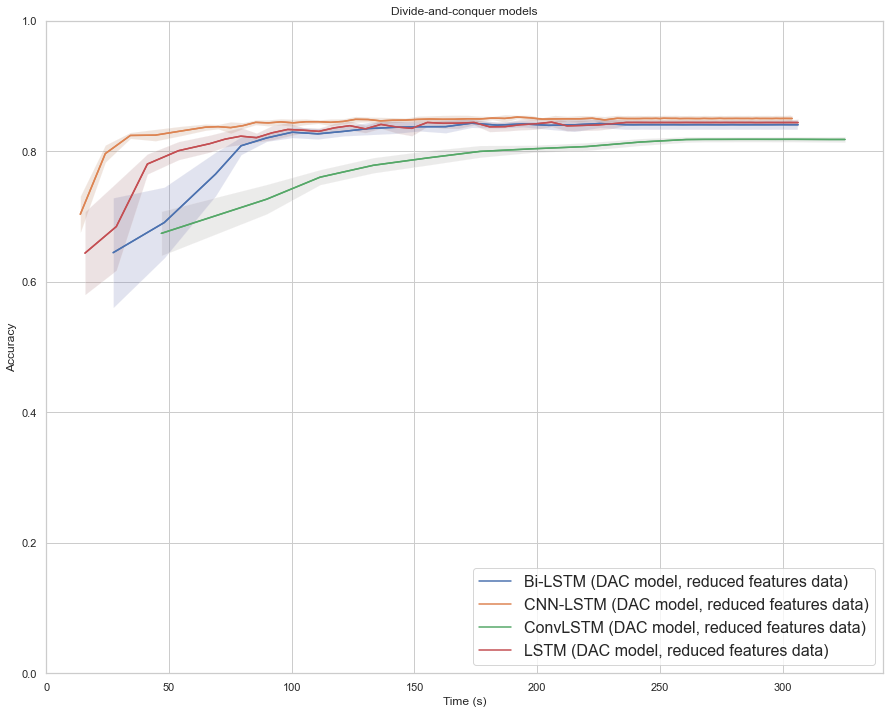

In [35]:
# plot just dac models which were trrained on the original data
plot_mean_and_sd('data_used_and_model_type', 'reduced_divide_and_conquer', types='one')

# Now make with better labels
labels = ['Bi-LSTM (DAC model, reduced features data)', 'CNN-LSTM (DAC model, reduced features data)', 'ConvLSTM (DAC model, reduced features data)', 'LSTM (DAC model, reduced features data)']
plot_mean_and_sd('data_used_and_model_type', 'reduced_divide_and_conquer', types='one', title="Divide-and-conquer models", labels=labels)

## Comparing models built on different datasets

### Oversampling

In [36]:
def t_tests_datasets(p_values_dict, dataset):
    
    # make list to store architectures, and add them to this list
    models = list()
    for model in model_plain_list:
            if model [-1]=='l':
                models.append(model[:-9])
                
    if (dataset=='balanced'):
        # get t test results (original vs balanced) for each architecture
        results = dict()
        for model in models:
            results[model] = t_test_pair(p_values_dict, model + '_original', model + '_balanced')
    
    if (dataset=='reduced'):
        # get t test results (original vs reduced) for each architecture
        results = dict()
        for model in models:
            results[model] = t_test_pair(p_values_dict, model + '_original', model + '_reduced')

    return results

In [37]:
t_tests_datasets(f1_p_values, 'balanced')

{'lstm_standard': Ttest_indResult(statistic=-1.056397656054136, pvalue=0.30913765383106284),
 'cnnlstm_standard': Ttest_indResult(statistic=1.484871239820356, pvalue=0.1554862037925758),
 'convlstm_standard': Ttest_indResult(statistic=0.7727183903914133, pvalue=0.4499153944774321),
 'bilstm_standard': Ttest_indResult(statistic=2.6520368056352353, pvalue=0.018471638226295058),
 'lstm_divide_and_conquer': Ttest_indResult(statistic=0.6359581455511668, pvalue=0.5328812141259416),
 'cnnlstm_divide_and_conquer': Ttest_indResult(statistic=2.191732281843145, pvalue=0.0485894288187649),
 'convlstm_divide_and_conquer': Ttest_indResult(statistic=2.714695493196506, pvalue=0.019992231271584022),
 'bilstm_divide_and_conquer': Ttest_indResult(statistic=1.4688376023298697, pvalue=0.16026209906706765)}

### Feature selection

In [38]:
t_tests_datasets(f1_p_values, 'reduced')

{'lstm_standard': Ttest_indResult(statistic=-13.135700611026962, pvalue=1.2465757519248699e-10),
 'cnnlstm_standard': Ttest_indResult(statistic=-7.040433831461153, pvalue=3.854112066737607e-06),
 'convlstm_standard': Ttest_indResult(statistic=-9.537806681756425, pvalue=3.6652197416571316e-08),
 'bilstm_standard': Ttest_indResult(statistic=-10.192316142623257, pvalue=6.848350207065864e-09),
 'lstm_divide_and_conquer': Ttest_indResult(statistic=-8.668819011383622, pvalue=1.4999848289544372e-06),
 'cnnlstm_divide_and_conquer': Ttest_indResult(statistic=-15.408043519845886, pvalue=5.80546354948873e-11),
 'convlstm_divide_and_conquer': Ttest_indResult(statistic=-1.8359534310137258, pvalue=0.08304540218967688),
 'bilstm_divide_and_conquer': Ttest_indResult(statistic=-5.610398945100832, pvalue=9.623937438623371e-05)}

### Overall

In [39]:
# function tomake list to store model type (whether dac or standard model)
def data_used_fn(df, model="model"):

    data_used = list()
    for i in range(len(df)):
        if ("original" in  df[model][i]):
            data_used.append("original")
        elif ("balanced" in df[model][i]):
            data_used.append("balanced")
        elif ("reduced" in df[model][i]):
            data_used.append("reduced")
            
    return data_used

In [40]:
# make function to get the mean accuracy/training times of epochs for the data, depending on what is selected, and plot it
def plot_mean_2(col, condition, style, types=None, title=None, labels='default', df=repeat_epoch_accuracies_test_df):
    
    # make df of mean accuracy and time per epoch
    test_mean_accuracies_times = df[df[col]==condition].fillna(method='ffill').groupby(['model_plain','epoch']).mean()
    test_mean_accuracies_times.reset_index(inplace=True)  
    
    # make column to show whether dac or standard
    test_mean_accuracies_times['model_type'] = model_type_fn(test_mean_accuracies_times)
    
    # make column to show data used
    test_mean_accuracies_times['data_used'] = data_used_fn(test_mean_accuracies_times, model = 'model_plain')
    
    # add column to show model family
    test_mean_accuracies_times['family'] = model_family_fn(test_mean_accuracies_times)
    # get sd
    sd = df[df[col]==condition].groupby(['model_plain','epoch']).std()
    sd_acc = list(sd.accuracy)
    test_mean_accuracies_times['sd_acc'] = sd_acc

    #get lower and upper bounds of sd
    test_mean_accuracies_times['acc_lower'] = test_mean_accuracies_times['accuracy'] - test_mean_accuracies_times['sd_acc']
    test_mean_accuracies_times['acc_upper'] = test_mean_accuracies_times['accuracy'] + test_mean_accuracies_times['sd_acc']

    # get min and max also
    mins = df[df[col]==condition].groupby(['model_plain','epoch']).min()
    maxes = df[df[col]==condition].groupby(['model_plain','epoch']).max()

    # convert the times to a list for the df
    min_acc = list(mins.accuracy)
    max_acc = list(maxes.accuracy)

    test_mean_accuracies_times['min_acc'] = min_acc
    test_mean_accuracies_times['max_acc'] = max_acc
    

    # get names of the models to be plotted
    models_list=unique(test_mean_accuracies_times['model_plain'])
    
    # if no labels inputted, set the legend labels to default 
    if (labels=='default'):
        labels=models_list
    
#     print(test_mean_accuracies_times)
        
    # plot the lines for each model    
    ax = sns.lineplot(x = 'time', 
              y = 'accuracy', 
              data=test_mean_accuracies_times,
              style=style,
              hue='family',
              ci='sd',
            )
    
    # add legend. user can set custom labels for aesthetics
    ax.legend(loc = 'lower right',
             labels=labels,
             prop={'size': 16})
    
    # limit for consistency
    ax.set(ylim=(0, 1),
          xlim=(0, None))
    
    ax.set(title=title,
       xlabel='Time (s)',
       ylabel='Accuracy')
    
    # add sd bars, if only comparing 1 type of model
    if types == "one":
        # iterate through, adding sd bars for each moddel selected by condition
        for i in range(len(models_list)):
            ax.fill_between('time',
                  'acc_lower', 
                  'acc_upper',
                  data=test_mean_accuracies_times[test_mean_accuracies_times['model_plain']==models_list[i]],
                  alpha=0.1)
            

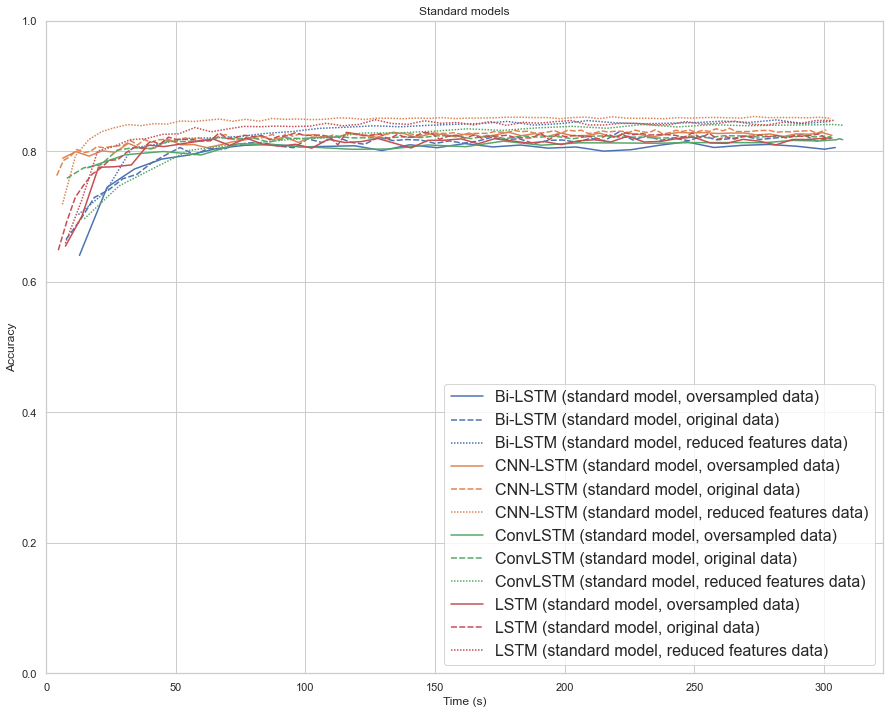

In [41]:
# plot all std models trained on original data
labels = ['Bi-LSTM (standard model, oversampled data)',
          'Bi-LSTM (standard model, original data)',
          'Bi-LSTM (standard model, reduced features data)',
          'CNN-LSTM (standard model, oversampled data)',
          'CNN-LSTM (standard model, original data)',
          'CNN-LSTM (standard model, reduced features data)',
          'ConvLSTM (standard model, oversampled data)',
          'ConvLSTM (standard model, original data)',
          'ConvLSTM (standard model, reduced features data)',
          'LSTM (standard model, oversampled data)',
          'LSTM (standard model, original data)',
          'LSTM (standard model, reduced features data)']
plot_mean_2('model_type', 'standard', style='data_used',types='two', labels=labels, title="Standard models")

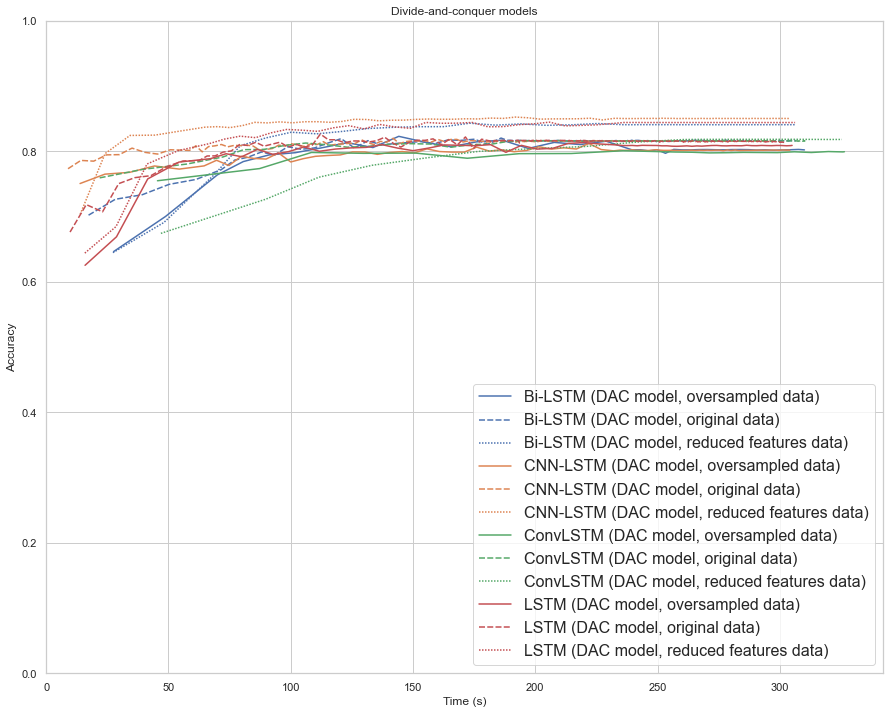

In [42]:
# plot all dac models trained on original data
labels = ['Bi-LSTM (DAC model, oversampled data)',
          'Bi-LSTM (DAC model, original data)',
          'Bi-LSTM (DAC model, reduced features data)',
          'CNN-LSTM (DAC model, oversampled data)',
          'CNN-LSTM (DAC model, original data)',
          'CNN-LSTM (DAC model, reduced features data)',
          'ConvLSTM (DAC model, oversampled data)',
          'ConvLSTM (DAC model, original data)',
          'ConvLSTM (DAC model, reduced features data)',
          'LSTM (DAC model, oversampled data)',
          'LSTM (DAC model, original data)',
          'LSTM (DAC model, reduced features data)']
plot_mean_2('model_type', 'divide_and_conquer', style='data_used',types='two', labels=labels,  title="Divide-and-conquer models" )

## Comaparing standard vs DAC models

In [43]:
# function to get t-tests comparing datasets
def t_tests_std_dac(p_values_dict):

    architectures = ['lstm', 'cnnlstm', 'convlstm', 'bilstm']
    
    counter=0
    
    # get t test results for each architecture
    results = dict()
    for architecture in architectures:
        results[architecture + '_original_data'] = t_test_pair(p_values_dict, architecture + '_standard_original', architecture + '_divide_and_conquer_original')
        results[architecture + '_oversampled_data'] = t_test_pair(p_values_dict, architecture + '_standard_balanced', architecture + '_divide_and_conquer_balanced')
        results[architecture + '_fr_data'] = t_test_pair(p_values_dict, architecture + '_standard_reduced', architecture + '_divide_and_conquer_reduced')

    return results

In [44]:
t_tests_std_dac(f1_p_values)

{'lstm_original_data': Ttest_indResult(statistic=0.6238527353308007, pvalue=0.5431612966298547),
 'lstm_oversampled_data': Ttest_indResult(statistic=1.911243722407384, pvalue=0.07226700675593695),
 'lstm_fr_data': Ttest_indResult(statistic=0.7930494764832365, pvalue=0.4382192037914088),
 'cnnlstm_original_data': Ttest_indResult(statistic=5.510990671465086, pvalue=3.510406194428106e-05),
 'cnnlstm_oversampled_data': Ttest_indResult(statistic=4.1274827581708315, pvalue=0.0008911651228454713),
 'cnnlstm_fr_data': Ttest_indResult(statistic=0.006646179281127916, pvalue=0.9947710128876132),
 'convlstm_original_data': Ttest_indResult(statistic=3.23830837474489, pvalue=0.004858548115039999),
 'convlstm_oversampled_data': Ttest_indResult(statistic=3.70547220403292, pvalue=0.0025109234566119115),
 'convlstm_fr_data': Ttest_indResult(statistic=13.624135881434725, pvalue=6.598029050457088e-11),
 'bilstm_original_data': Ttest_indResult(statistic=0.4313663104079657, pvalue=0.6735936251986469),
 'bil

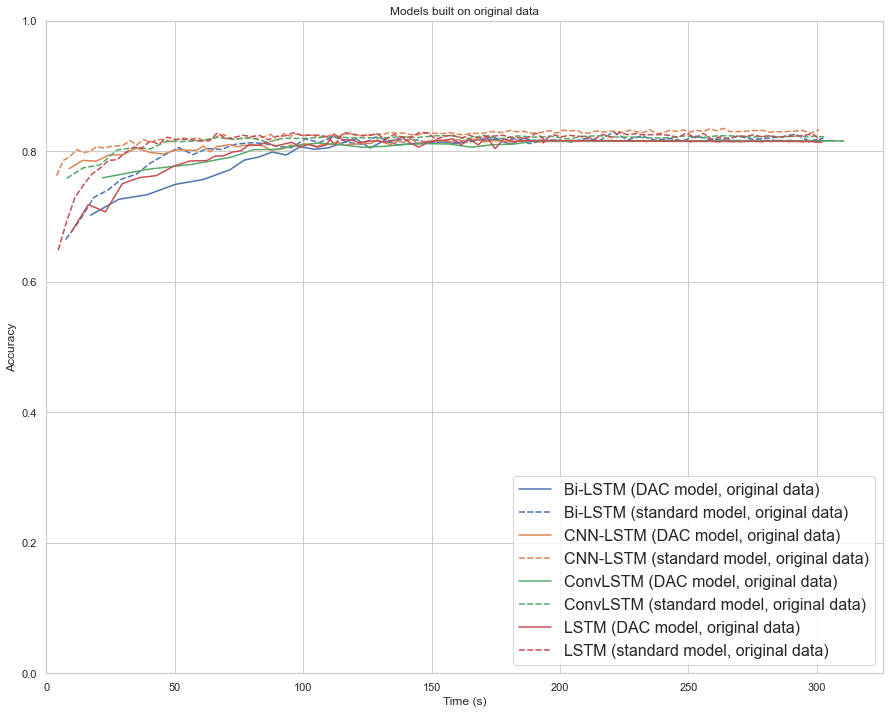

In [45]:
# plot all models trained on original data
labels = ['Bi-LSTM (DAC model, original data)',
          'Bi-LSTM (standard model, original data)',
          'CNN-LSTM (DAC model, original data)',
          'CNN-LSTM (standard model, original data)',
          'ConvLSTM (DAC model, original data)',
          'ConvLSTM (standard model, original data)',
          'LSTM (DAC model, original data)',
          'LSTM (standard model, original data)']
plot_mean_2('data_used', 'original', style='model_type',types='two', labels=labels, title="Models built on original data")

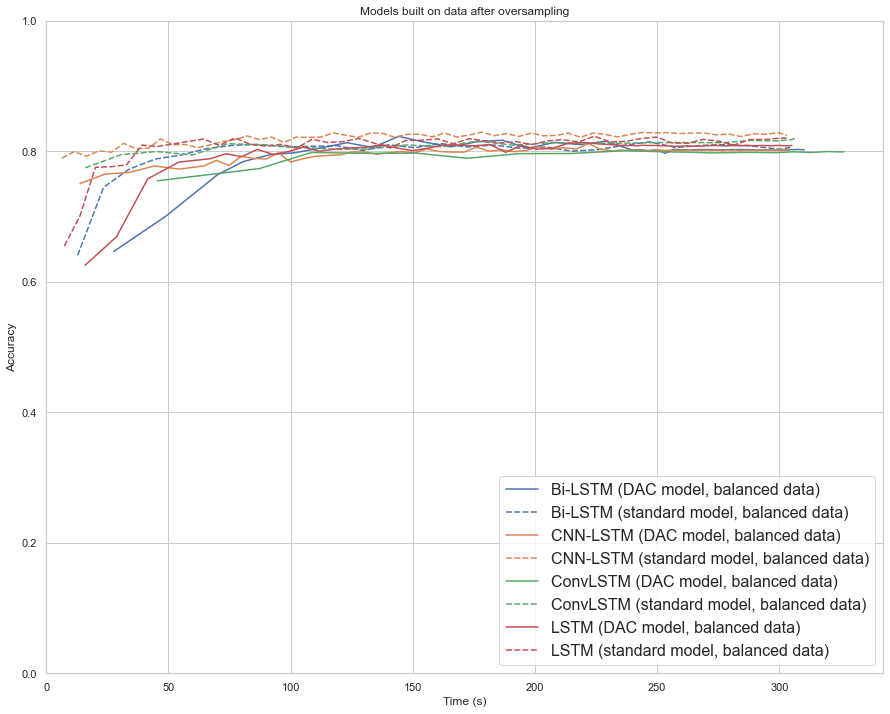

In [46]:
# plot all dac models trained on oversampled data
labels = ['Bi-LSTM (DAC model, balanced data)',
          'Bi-LSTM (standard model, balanced data)',
          'CNN-LSTM (DAC model, balanced data)',
          'CNN-LSTM (standard model, balanced data)',
          'ConvLSTM (DAC model, balanced data)',
          'ConvLSTM (standard model, balanced data)',
          'LSTM (DAC model, balanced data)',
          'LSTM (standard model, balanced data)']
plot_mean_2('data_used', 'balanced', style='model_type',types='two', labels = labels, title="Models built on data after oversampling" )

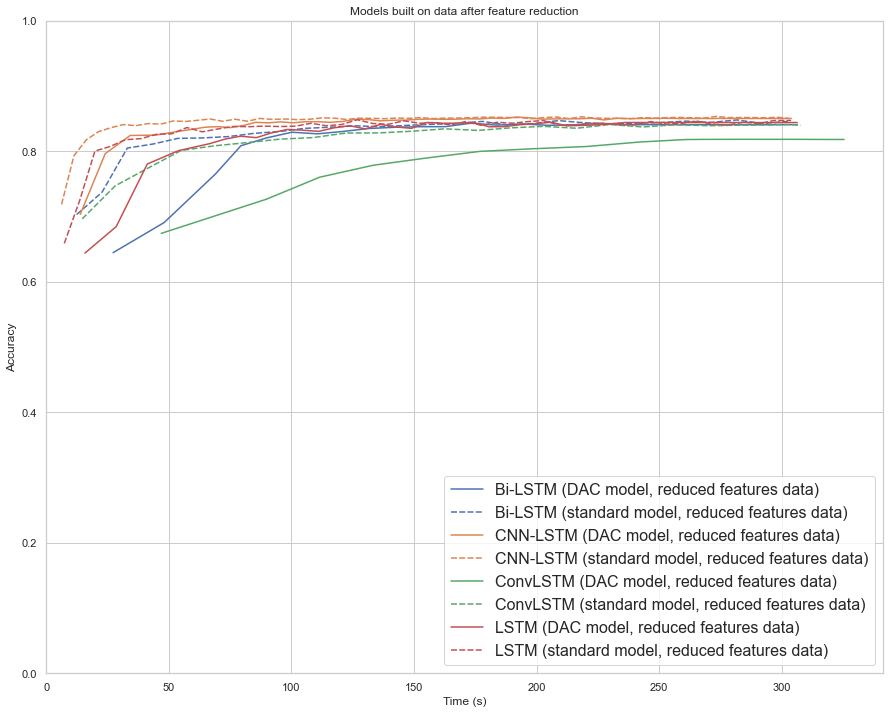

In [47]:
# plot all dac models trained on fr data
labels = ['Bi-LSTM (DAC model, reduced features data)',
          'Bi-LSTM (standard model, reduced features data)',
          'CNN-LSTM (DAC model, reduced features data)',
          'CNN-LSTM (standard model, reduced features data)',
          'ConvLSTM (DAC model, reduced features data)',
          'ConvLSTM (standard model, reduced features data)',
          'LSTM (DAC model, reduced features data)',
          'LSTM (standard model, reduced features data)']
plot_mean_2('data_used', 'reduced', style='model_type',types='two', labels = labels, title="Models built on data after feature reduction" )

## Box plot of all models for discussion

In [48]:
x = []

for i in range(len(repeat_metrics_df)):
    if repeat_metrics_df['data_used'][i] == 'original':
        x.append('Original dataset')
    elif repeat_metrics_df['data_used'][i] == 'balanced':
        x.append('Oversampled dataset')
    else:
        x.append('Dataset after feature selection')
        
repeat_metrics_df['data_used_pretty'] = x

In [49]:
x = []

for i in range(len(repeat_metrics_df)):
    if repeat_metrics_df['family'][i] == 'lstm':
        x.append('Vanilla LSTM')
    elif repeat_metrics_df['family'][i] == 'cnnlstm':
        x.append('CNN-LSTM')
    elif repeat_metrics_df['family'][i] == 'convlstm':
        x.append('ConvLSTM')
    else:
        x.append('Bi-directional LSTM')
        
repeat_metrics_df['architecture'] = x

In [50]:
# set figure size globally
sns.set(rc={'figure.figsize':(15,12)}, font_scale=1.5)
sns.set_style('whitegrid')

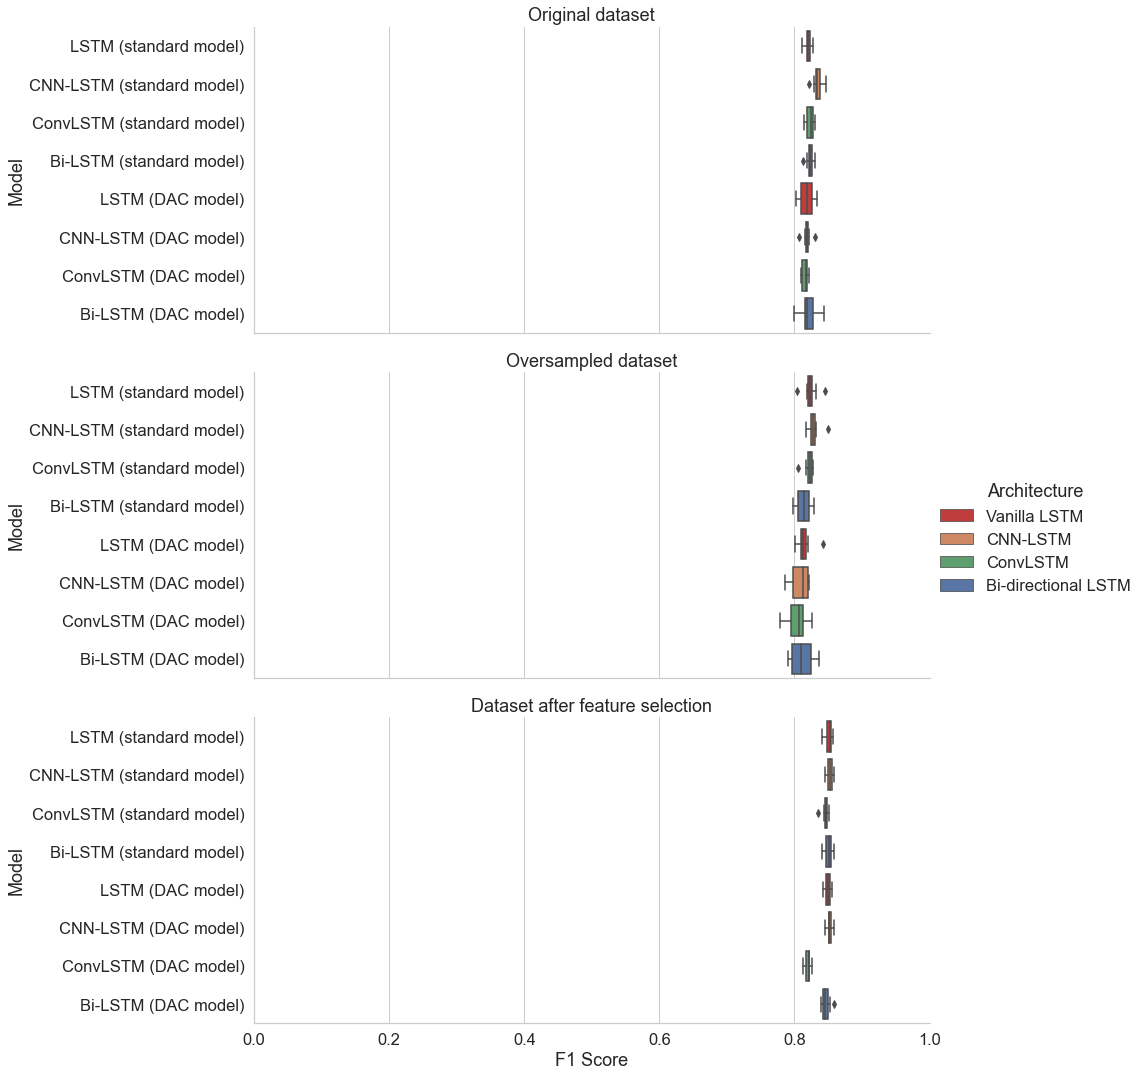

In [51]:
model_labels = ['LSTM (standard model)',
               'CNN-LSTM (standard model)',
               'ConvLSTM (standard model)',
               'Bi-LSTM (standard model)',
               'LSTM (DAC model)',
               'CNN-LSTM (DAC model)',
               'ConvLSTM (DAC model)',
               'Bi-LSTM (DAC model)']

colours ={'Bi-directional LSTM': "C0", "CNN-LSTM": "C1", "ConvLSTM": "C2", "Vanilla LSTM": "tab:red", "Total": "k"}

ax = sns.catplot(y='model_plain',
                 x='f1_score',
                 kind='box',
                 hue='architecture',
                 palette = colours,
                 row='data_used_pretty' ,
                 dodge =False,
                 sharey=False,
                 data=repeat_metrics_df,
                height=5,
                aspect=3)

ax.set_titles(template='{row_name}')

ax.set_xlabels('F1 Score')
ax.set_ylabels('Model')

ax.set(yticklabels=model_labels)

ax.set(xlim=(0, 1))

ax.legend.set_title('Architecture')

ax.legend.set_label('Architecture')


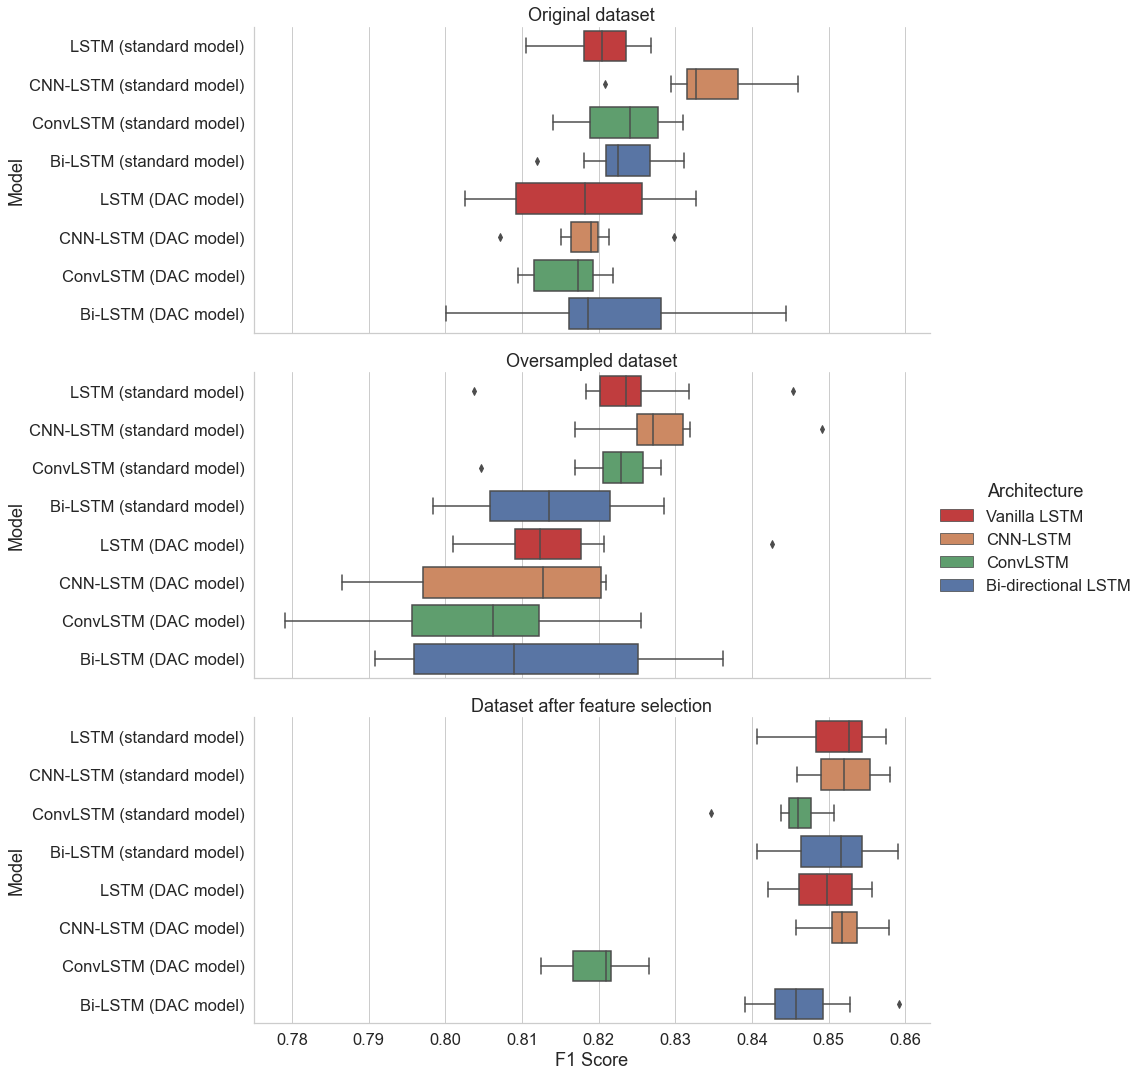

In [52]:
model_labels = ['LSTM (standard model)',
               'CNN-LSTM (standard model)',
               'ConvLSTM (standard model)',
               'Bi-LSTM (standard model)',
               'LSTM (DAC model)',
               'CNN-LSTM (DAC model)',
               'ConvLSTM (DAC model)',
               'Bi-LSTM (DAC model)']

colours ={'Bi-directional LSTM': "C0", "CNN-LSTM": "C1", "ConvLSTM": "C2", "Vanilla LSTM": "tab:red", "Total": "k"}

ax = sns.catplot(y='model_plain',
                 x='f1_score',
                 kind='box',
                 hue='architecture',
                 palette = colours,
                 row='data_used_pretty' ,
                 dodge =False,
                 sharey=False,
                 data=repeat_metrics_df,
                height=5,
                aspect=3)

ax.set_titles(template='{row_name}')

ax.set_xlabels('F1 Score')
ax.set_ylabels('Model')

ax.set(yticklabels=model_labels)

ax.set(xlim=(None, None))

ax.legend.set_title('Architecture')

ax.legend.set_label('Architecture')


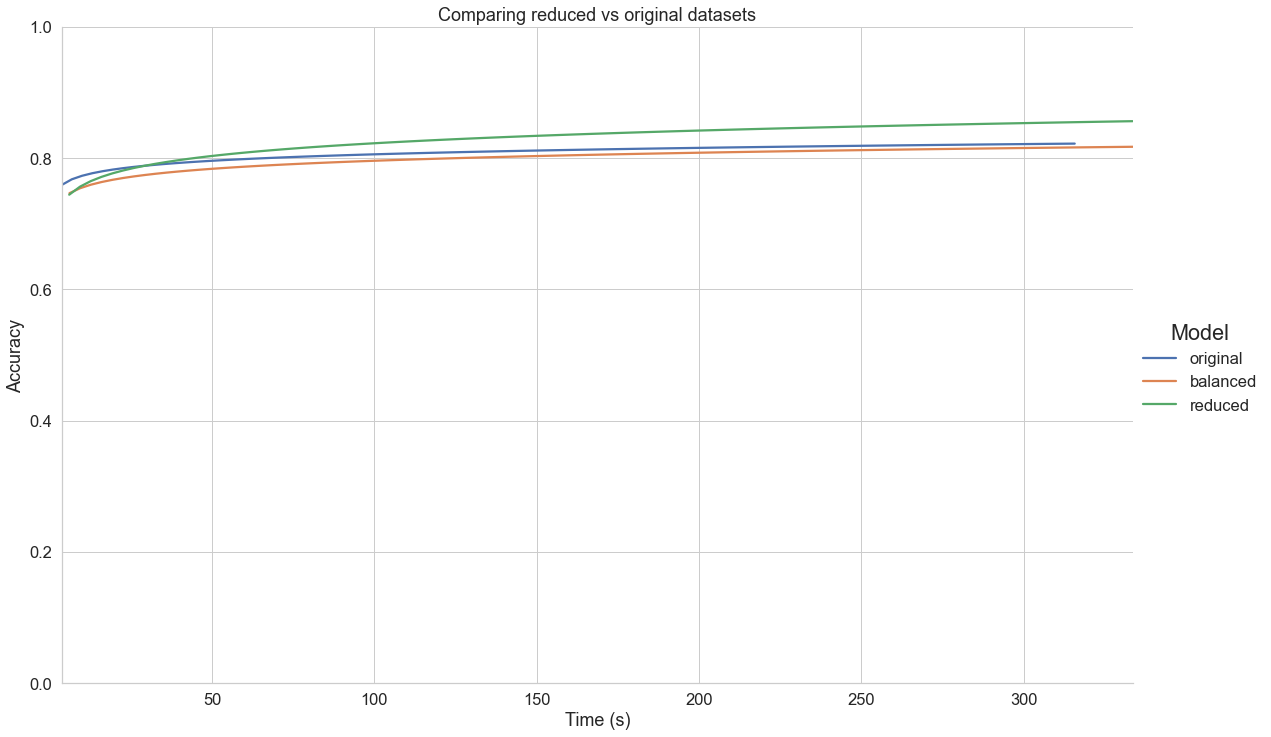

In [53]:
ax = sns.lmplot(x = 'time', 
                y = 'accuracy', 
                data=repeat_epoch_accuracies_test_df, 
                hue='data_used',
                logx=True,
                scatter=False,
                ci=None,
                truncate=True,
                height=10,
                aspect=1.6,
                scatter_kws={"s": 1}
               )


ax.set(title='Comparing reduced vs original datasets',
       xlabel='Time (s)',
       ylabel='Accuracy')

ax.legend.set_title('Model',prop={'size':'large'})

ax.set(ylim=(0, 1))

plt.show()


## Plotting best models

In [54]:
# function tomake list to store model type (whether dac or standard model)
def data_used_fn(df, model="model"):

    data_used = list()
    for i in range(len(df)):
        if ("original" in  df[model][i]):
            data_used.append("original")
        elif ("balanced" in df[model][i]):
            data_used.append("balanced")
        elif ("reduced" in df[model][i]):
            data_used.append("reduced")
            
    return data_used

In [55]:
# make function to get the mean accuracy/training times of epochs for the data, depending on what is selected, and plot it
def plot_mean_3(col, condition, style, types=None, title=None, labels='default', df=repeat_epoch_accuracies_test_df):
    
    # make df of mean accuracy and time per epoch
    test_mean_accuracies_times = df[df[col].isin(condition)].fillna(method='ffill').groupby(['model_plain','epoch']).mean()
    test_mean_accuracies_times.reset_index(inplace=True)  
    
    # make column to show whether dac or standard
    test_mean_accuracies_times['model_type'] = model_type_fn(test_mean_accuracies_times)
    
    # make column to show data used
    test_mean_accuracies_times['data_used'] = data_used_fn(test_mean_accuracies_times, 'model_plain')
    
    # add column to show model family
    test_mean_accuracies_times['family'] = model_family_fn(test_mean_accuracies_times) 

    # get names of the models to be plotted
    models_list=unique(test_mean_accuracies_times['model_plain'])
    
    # if no labels inputted, set the legend labels to default 
    if (labels=='default'):
        labels=None
        
    colours ={'bilstm': "C0", "cnnlstm": "C1", "convlstm": "C2", "lstm": "tab:red", "Total": "k"}
    
    # plot the lines for each model    
    ax = sns.lineplot(x = 'time', 
              y = 'accuracy', 
              data=test_mean_accuracies_times,
              style=style,
              hue='family',
              palette = colours,
              ci='sd',
            )
    
    # add legend. user can set custom labels for aesthetics
    ax.legend(loc = 'lower right',
             labels=labels,
             prop={'size': 16})
    
    # limit for consistency
    ax.set(ylim=(0, 1),
          xlim=(0, None))
    
    ax.set(title=title,
       xlabel='Time (s)',
       ylabel='Accuracy')
    
    print(test_mean_accuracies_times.model_type)
    

In [56]:
repeat_epoch_accuracies_test_df.model_plain.unique()

array(['lstm_standard_original', 'cnnlstm_standard_original',
       'convlstm_standard_original', 'bilstm_standard_original',
       'lstm_standard_balanced', 'cnnlstm_standard_balanced',
       'convlstm_standard_balanced', 'bilstm_standard_balanced',
       'lstm_standard_reduced', 'cnnlstm_standard_reduced',
       'convlstm_standard_reduced', 'bilstm_standard_reduced',
       'lstm_divide_and_conquer_original',
       'cnnlstm_divide_and_conquer_original',
       'convlstm_divide_and_conquer_original',
       'bilstm_divide_and_conquer_original',
       'lstm_divide_and_conquer_balanced',
       'cnnlstm_divide_and_conquer_balanced',
       'convlstm_divide_and_conquer_balanced',
       'bilstm_divide_and_conquer_balanced',
       'lstm_divide_and_conquer_reduced',
       'cnnlstm_divide_and_conquer_reduced',
       'convlstm_divide_and_conquer_reduced',
       'bilstm_divide_and_conquer_reduced'], dtype=object)

0       standard
1       standard
2       standard
3       standard
4       standard
          ...   
2640    standard
2641    standard
2642    standard
2643    standard
2644    standard
Name: model_type, Length: 2645, dtype: object


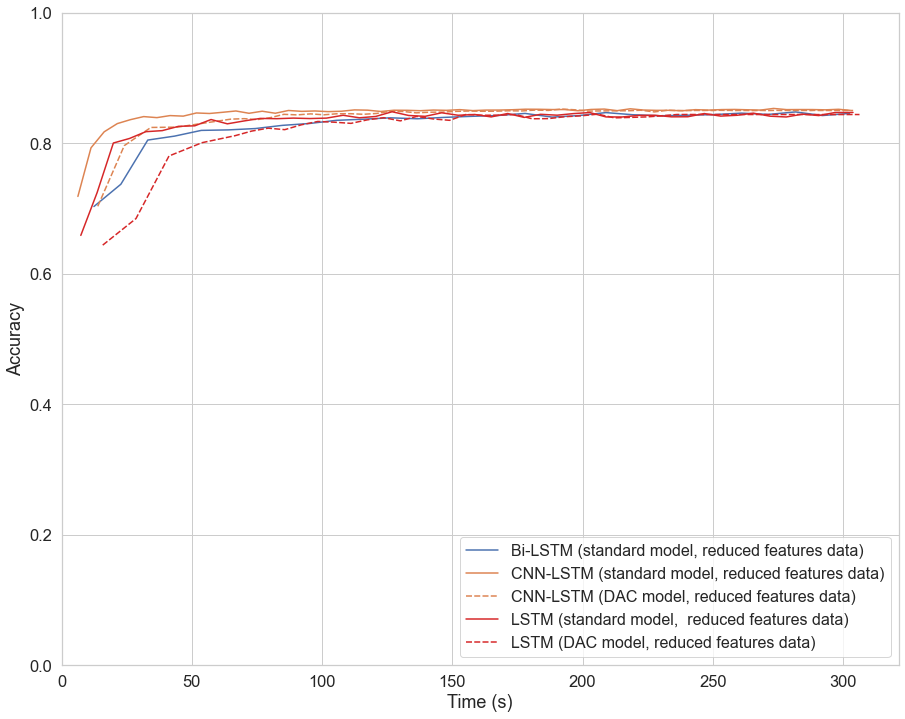

In [57]:
# make a list of the best perfroming models to plot
best_models_list = ['cnnlstm_standard_reduced', 'lstm_standard_reduced', 'bilstm_standard_reduced', 'lstm_divide_and_conquer_reduced', 'cnnlstm_divide_and_conquer_reduced']

labels = ['Bi-LSTM (standard model, reduced features data)',
          'CNN-LSTM (standard model, reduced features data)',
          'CNN-LSTM (DAC model, reduced features data)',
          'LSTM (standard model,  reduced features data)',
          'LSTM (DAC model, reduced features data)'
         ]


plot_mean_3('model_plain', best_models_list, style='model_type', labels = labels)